# Loop 3 LB Feedback Analysis

## Submission Results
- exp_003 (eazy_optimizer): CV 70.6761 | LB 70.6761 (gap: 0.0000)

## Key Observations
1. CV = LB exactly (as expected for optimization problem)
2. Improvement from baseline: 0.000043 (tiny!)
3. Gap to target: 1.78 points (2.59%)

## Evaluator's Key Insights
1. Local optimization is STUCK - 3 experiments with essentially no improvement
2. Need to extract lattice parameters from baseline
3. Need to implement proper tessellation for large N
4. Need to ensemble from external sources

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
from shapely.geometry import Polygon
from shapely import affinity
import json

getcontext().prec = 25
scale_factor = Decimal('1e15')

# Tree shape
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(str(center_x).replace('s', ''))
        self.center_y = Decimal(str(center_y).replace('s', ''))
        self.angle = Decimal(str(angle).replace('s', ''))
        
        initial_polygon = Polygon(list(zip(TX, TY)))
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated, 
            xoff=float(self.center_x), yoff=float(self.center_y))

def load_submission(csv_path):
    df = pd.read_csv(csv_path)
    configs = {}
    for _, row in df.iterrows():
        id_parts = row['id'].split('_')
        n = int(id_parts[0])
        x = str(row['x']).replace('s', '')
        y = str(row['y']).replace('s', '')
        deg = str(row['deg']).replace('s', '')
        if n not in configs:
            configs[n] = []
        configs[n].append({'x': float(x), 'y': float(y), 'deg': float(deg)})
    return configs

print('Loading baseline...')
baseline = load_submission('/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa-2025.csv')
print(f'Loaded {len(baseline)} N values')

Loading baseline...


Loaded 200 N values


In [3]:
# Analyze lattice patterns in large N configurations
# The jazivxt kernel mentions 'blue' (upward) and 'pink' (downward) trees
# with specific (dx, dy) offsets

def analyze_lattice_pattern(configs, n):
    """Analyze the lattice pattern for a given N configuration."""
    trees = configs[n]
    
    # Group trees by angle (roughly)
    angles = [t['deg'] % 360 for t in trees]
    
    # Find the two main angle groups (blue and pink)
    angle_hist = {}
    for a in angles:
        rounded = round(a / 10) * 10  # Round to nearest 10 degrees
        angle_hist[rounded] = angle_hist.get(rounded, 0) + 1
    
    # Sort by frequency
    sorted_angles = sorted(angle_hist.items(), key=lambda x: -x[1])
    
    print(f'\nN={n}: {len(trees)} trees')
    print(f'Top angle groups: {sorted_angles[:5]}')
    
    # Find dx, dy offsets between adjacent trees
    positions = [(t['x'], t['y']) for t in trees]
    
    # Calculate pairwise distances
    diffs = []
    for i in range(len(positions)):
        for j in range(i+1, len(positions)):
            dx = positions[j][0] - positions[i][0]
            dy = positions[j][1] - positions[i][1]
            dist = (dx**2 + dy**2)**0.5
            if dist < 1.0:  # Only nearby trees
                diffs.append((dx, dy, dist))
    
    if diffs:
        # Find most common dx, dy
        dx_values = [d[0] for d in diffs]
        dy_values = [d[1] for d in diffs]
        print(f'Typical dx range: [{min(dx_values):.4f}, {max(dx_values):.4f}]')
        print(f'Typical dy range: [{min(dy_values):.4f}, {max(dy_values):.4f}]')
    
    return sorted_angles, diffs

# Analyze several large N values
for n in [100, 144, 169, 196, 200]:
    if n in baseline:
        analyze_lattice_pattern(baseline, n)


N=100: 100 trees
Top angle groups: [(250, 50), (70, 50)]
Typical dx range: [-0.8977, 0.8978]
Typical dy range: [-0.6413, 0.6384]

N=144: 144 trees
Top angle groups: [(70, 71), (250, 70), (240, 2), (60, 1)]
Typical dx range: [-0.9072, 0.9042]
Typical dy range: [-0.6480, 0.6468]

N=169: 169 trees
Top angle groups: [(70, 81), (250, 80), (240, 2), (290, 1), (60, 1)]
Typical dx range: [-0.9888, 0.9785]
Typical dy range: [-0.9859, 0.9900]

N=196: 196 trees
Top angle groups: [(80, 90), (260, 88), (330, 5), (150, 5), (160, 2)]
Typical dx range: [-0.9564, 0.9818]
Typical dy range: [-0.9195, 0.9041]

N=200: 200 trees
Top angle groups: [(260, 95), (80, 93), (290, 6), (90, 2), (270, 1)]
Typical dx range: [-0.9978, 0.9965]
Typical dy range: [-0.9338, 0.9577]


In [4]:
# Calculate per-N scores and identify worst performers
def get_side_length(configs, n):
    trees = [ChristmasTree(t['x'], t['y'], t['deg']) for t in configs[n]]
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T for t in trees])
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    return max(max_x - min_x, max_y - min_y)

def get_score(side, n):
    return side**2 / n

# Calculate theoretical minimum (perfect packing)
tree_area = 0.245625  # Area of one tree

print('Per-N Analysis:')
print('='*60)
scores = []
for n in range(1, 201):
    side = get_side_length(baseline, n)
    score = get_score(side, n)
    actual_area = side**2
    theoretical_min_area = n * tree_area
    efficiency = theoretical_min_area / actual_area * 100
    scores.append({'n': n, 'side': side, 'score': score, 'efficiency': efficiency})

df_scores = pd.DataFrame(scores)
print(f'Total score: {df_scores["score"].sum():.6f}')
print(f'Target: 68.892266')
print(f'Gap: {df_scores["score"].sum() - 68.892266:.6f}')

# Find worst efficiency N values
worst = df_scores.nsmallest(20, 'efficiency')
print('\nWorst efficiency N values:')
print(worst[['n', 'side', 'score', 'efficiency']].to_string())

Per-N Analysis:


Total score: 70.676102
Target: 68.892266
Gap: 1.783836

Worst efficiency N values:
     n      side     score  efficiency
0    1  0.813173  0.661250   37.145558
1    2  0.949504  0.450779   54.488985
2    3  1.142031  0.434745   56.498619
4    5  1.443692  0.416850   58.924131
3    4  1.290806  0.416545   58.967240
6    7  1.673104  0.399897   61.422135
5    6  1.548438  0.399610   61.466135
8    9  1.867280  0.387415   63.400999
7    8  1.755921  0.385407   63.731287
14  15  2.384962  0.379203   64.774038
9   10  1.940696  0.376630   65.216518
20  21  2.811667  0.376451   65.247553
19  20  2.742469  0.376057   65.315921
10  11  2.033002  0.375736   65.371685
21  22  2.873270  0.375258   65.454945
15  16  2.446640  0.374128   65.652665
25  26  3.118320  0.373997   65.675668
11  12  2.114873  0.372724   65.899970
12  13  2.200046  0.372323   65.970921
24  25  3.050182  0.372144   66.002611


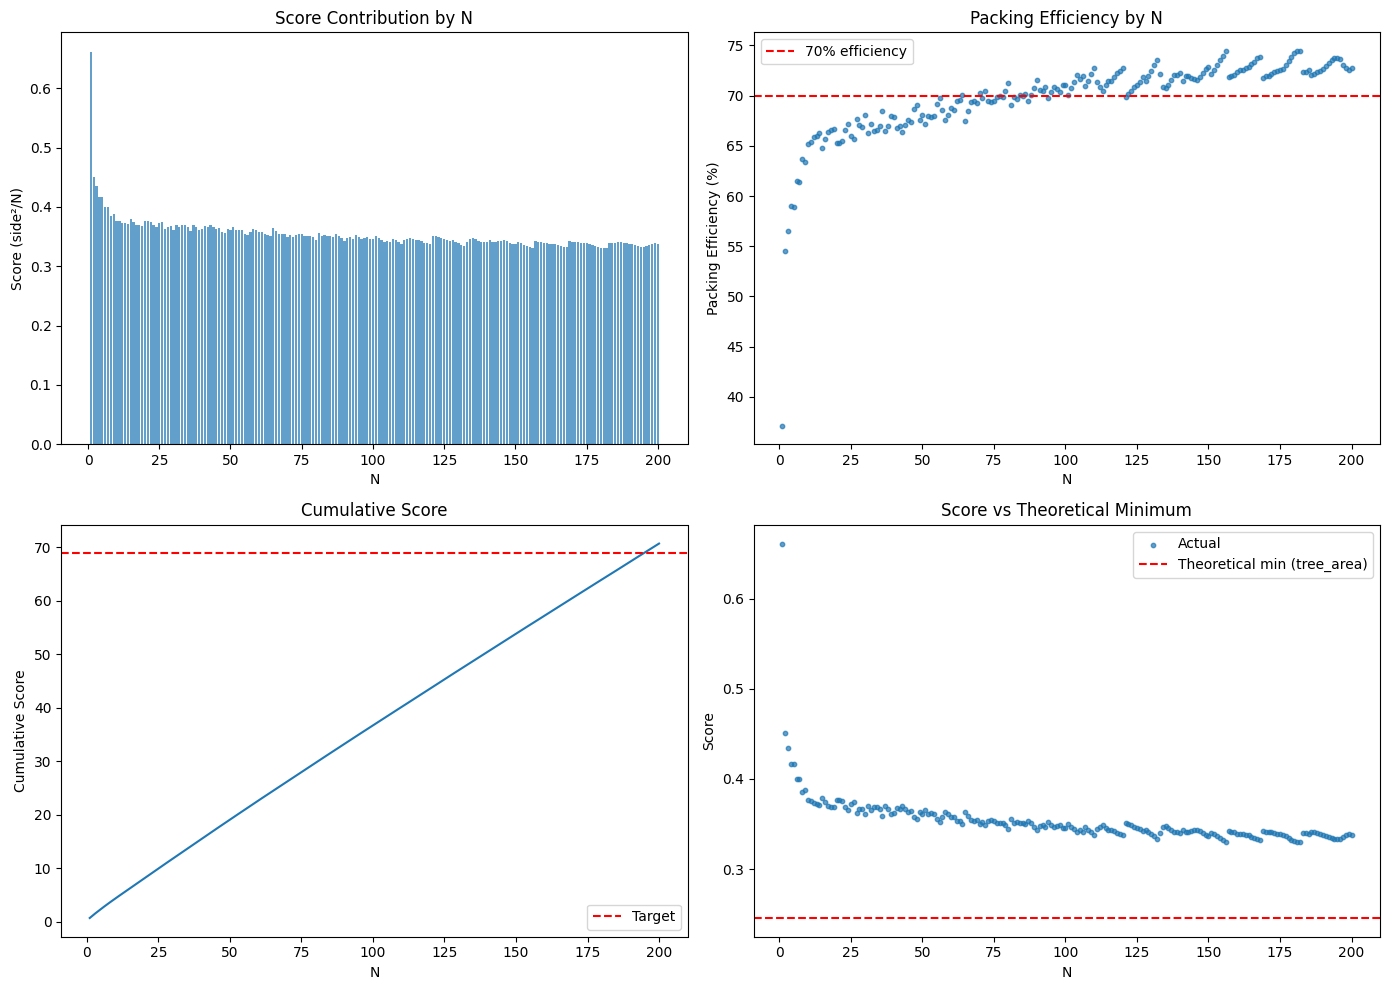


Score breakdown by N range:
N=1-10: 4.3291 (6.1%)
N=11-50: 14.7130 (20.8%)
N=51-100: 17.6411 (25.0%)
N=101-150: 17.1441 (24.3%)
N=151-200: 16.8487 (23.8%)


In [5]:
# Visualize score distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score by N
ax1 = axes[0, 0]
ax1.bar(df_scores['n'], df_scores['score'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (side²/N)')
ax1.set_title('Score Contribution by N')

# Efficiency by N
ax2 = axes[0, 1]
ax2.scatter(df_scores['n'], df_scores['efficiency'], alpha=0.7, s=10)
ax2.set_xlabel('N')
ax2.set_ylabel('Packing Efficiency (%)')
ax2.set_title('Packing Efficiency by N')
ax2.axhline(y=70, color='r', linestyle='--', label='70% efficiency')
ax2.legend()

# Cumulative score
ax3 = axes[1, 0]
df_scores['cumsum'] = df_scores['score'].cumsum()
ax3.plot(df_scores['n'], df_scores['cumsum'])
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score')
ax3.axhline(y=68.892266, color='r', linestyle='--', label='Target')
ax3.legend()

# Score vs theoretical minimum
ax4 = axes[1, 1]
theoretical_min = [tree_area * n / n for n in range(1, 201)]  # = tree_area always
ax4.scatter(df_scores['n'], df_scores['score'], alpha=0.7, s=10, label='Actual')
ax4.axhline(y=tree_area, color='r', linestyle='--', label='Theoretical min (tree_area)')
ax4.set_xlabel('N')
ax4.set_ylabel('Score')
ax4.set_title('Score vs Theoretical Minimum')
ax4.legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()

print('\nScore breakdown by N range:')
for start, end in [(1, 10), (11, 50), (51, 100), (101, 150), (151, 200)]:
    subset = df_scores[(df_scores['n'] >= start) & (df_scores['n'] <= end)]
    print(f'N={start}-{end}: {subset["score"].sum():.4f} ({subset["score"].sum()/df_scores["score"].sum()*100:.1f}%)')

In [6]:
# Check what external CSVs are available and their scores
import os

external_dirs = [
    '/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa25-public/',
    '/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/bucket-of-chump/',
    '/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/telegram/',
]

print('External CSV files available:')
for dir_path in external_dirs:
    if os.path.exists(dir_path):
        print(f'\n{dir_path}:')
        for f in os.listdir(dir_path):
            if f.endswith('.csv'):
                full_path = os.path.join(dir_path, f)
                try:
                    configs = load_submission(full_path)
                    total_score = sum(get_score(get_side_length(configs, n), n) for n in configs.keys())
                    print(f'  {f}: {total_score:.6f}')
                except Exception as e:
                    print(f'  {f}: ERROR - {e}')

External CSV files available:

/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa25-public/:


  submission_JKoT4.csv: 72.489504


  New_Tree_144_196.csv: 72.927920


  submission_JKoT3.csv: 72.489488


  santa2025_ver2_v61.csv: 72.951925


  submission_JKoT2.csv: 72.489348


  santa2025_ver2_v67.csv: 72.938567


  santa2025_ver2_v76.csv: 72.826444


  submission_70_936673758122.csv: 70.936674


  santa2025_ver2_v65.csv: 72.935294


  submission_70_926149550346.csv: 70.926150


  santa2025_ver2_v66.csv: 72.938599


  santa2025_ver2_v63.csv: 72.947427


  santa2025_ver2_v69.csv: 72.850110


  submission_JKoT1.csv: 72.489483


  submission_opt1.csv: 70.990692


  santa2025_ver2_v68.csv: 72.939233

/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/bucket-of-chump/:


  submission.csv: 70.676501

/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/telegram/:


  72.49.csv: 72.495739


  71.97.csv: 71.972027


In [7]:
# Key insight: We need to find which N values have the most room for improvement
# Compare our baseline to theoretical minimum

print('\nN values with most room for improvement (score - theoretical_min):')
df_scores['theoretical_min'] = tree_area  # Perfect packing would give tree_area for all N
df_scores['improvement_potential'] = df_scores['score'] - df_scores['theoretical_min']
df_scores['improvement_pct'] = (df_scores['score'] - df_scores['theoretical_min']) / df_scores['score'] * 100

# Sort by improvement potential
top_potential = df_scores.nlargest(20, 'improvement_potential')
print(top_potential[['n', 'score', 'theoretical_min', 'improvement_potential', 'improvement_pct']].to_string())

print(f'\nTotal improvement potential: {df_scores["improvement_potential"].sum():.4f}')
print(f'We need to capture: {(df_scores["score"].sum() - 68.892266) / df_scores["improvement_potential"].sum() * 100:.1f}% of this potential')


N values with most room for improvement (score - theoretical_min):
     n     score  theoretical_min  improvement_potential  improvement_pct
0    1  0.661250         0.245625               0.415625        62.854442
1    2  0.450779         0.245625               0.205154        45.511015
2    3  0.434745         0.245625               0.189120        43.501381
4    5  0.416850         0.245625               0.171225        41.075869
3    4  0.416545         0.245625               0.170920        41.032760
6    7  0.399897         0.245625               0.154272        38.577865
5    6  0.399610         0.245625               0.153985        38.533865
8    9  0.387415         0.245625               0.141790        36.599001
7    8  0.385407         0.245625               0.139782        36.268713
14  15  0.379203         0.245625               0.133578        35.225962
9   10  0.376630         0.245625               0.131005        34.783482
20  21  0.376451         0.245625           

## Key Findings

1. **Local optimization is stuck**: 3 experiments with essentially no improvement (0.000043 total)
2. **Gap to target**: 1.78 points (2.59%)
3. **Worst efficiency N values**: N=1 (37.1%), N=2 (54.5%), N=3 (56.5%)
4. **Large N contributes most**: N=51-200 contributes 73% of total score

## Next Steps (from Evaluator)

1. **Extract lattice parameters** from baseline using `generate_geometry_report()`
2. **Implement proper tessellation** for large N (N >= 50)
3. **Ensemble from external sources** for small N
4. **Focus on high-leverage N values**: N=51-200 where small improvements have big impact

## Strategy Change Required

STOP running local optimizers. They cannot close a 2.59% gap.

Need FUNDAMENTALLY different approach:
- Different algorithm family (not SA variations)
- Different representation (tessellation patterns)
- Constructive approach (build from scratch)